In [1]:
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima.arima import ADFTest, auto_arima
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Sunspots.csv', header = 0, parse_dates = [0], index_col = 0, squeeze = True)
original_data_df = original_data_df.reset_index(drop = True)
original_data_df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [3]:
'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sunspot num']
print(original_data_df.head())

        Month  Sunspot num
0  1749-01-31         96.7
1  1749-02-28        104.3
2  1749-03-31        116.7
3  1749-04-30         92.8
4  1749-05-31        141.7


In [4]:
'''
날짜 datetime 타입으로 변환
'''
original_data_date_list = original_data_df['Month'].tolist()
original_data_date_list = pd.to_datetime(original_data_date_list)
original_data_df['Month'] = original_data_date_list
print(original_data_df.head())
type(original_data_df['Month'][0])

       Month  Sunspot num
0 1749-01-31         96.7
1 1749-02-28        104.3
2 1749-03-31        116.7
3 1749-04-30         92.8
4 1749-05-31        141.7


pandas._libs.tslibs.timestamps.Timestamp

In [5]:
'''
Month 컬럼 인덱스 부여
'''
original_data_df = original_data_df.set_index('Month').astype(int) # Month 컬럼에 인덱스 부여
original_data_df = original_data_df[:300]
print(original_data_df.head())

            Sunspot num
Month                  
1749-01-31           96
1749-02-28          104
1749-03-31          116
1749-04-30           92
1749-05-31          141


In [6]:
'''
결측치 확인
'''
print(original_data_df.isnull().sum())

'''
train, test 데이터 분리
'''
train_data_df = original_data_df[:round(len(original_data_df) * 0.8)]
test_data_df = original_data_df[round(len(original_data_df) * 0.8):]
print(len(original_data_df)) # 3252 train:2500, test:752
print(len(train_data_df) + len(test_data_df))

Sunspot num    0
dtype: int64
300
300


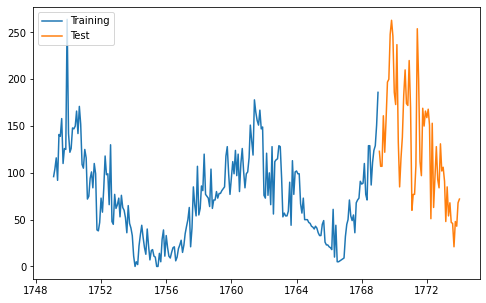

In [7]:
'''
데이터 시각화
'''
plt.figure(figsize = (8, 5))
plt.plot(train_data_df, label = 'Training')
plt.plot(test_data_df, label = 'Test')
plt.legend(loc = 'upper left')
plt.show()

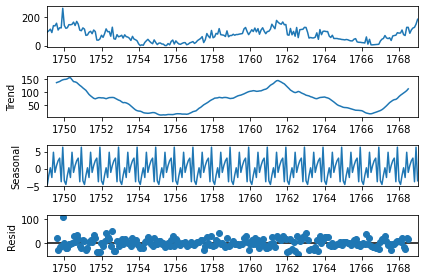

In [8]:
'''
decomposition 확인 (trend, seasonal, resid)
'''
result = seasonal_decompose(train_data_df, model = 'additive')
re_plot = result.plot()
plt.show()

In [9]:
'''
adfuller() 사용
'''
# stationary 확인
train_data_np = train_data_df.values
result = adfuller(train_data_np)
print("ADF Statistic: {:.6f}".format(result[0]))
print("p-value: {:.6f}".format(result[1], end = ''))

if result[1] <= 0.05:
    print(" => Stationary Data")
else:
    print(" => Non-Stationary Data")

ADF Statistic: -2.150061
p-value: 0.224867
 => Non-Stationary Data


In [10]:
'''
train 데이터 분석
'''
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train_data_df)

(0.7229052626069848, True)

In [11]:
'''
경고 무시
'''
warnings.filterwarnings('ignore')

In [12]:
'''
ARIMA 모델 학습

Auto ARIMA 탐색 범위 설정
  * ARIMA 차수 p : 0 ~ 5
  * ARIMA 차수 d : 1 고정
  * ARIMA 차수 q : 0 ~ 5
  * Seasonality 차수 P : 0 ~ 5
  * Seasonality 차수 D : 1 고정
  * Seasonality 차수 Q : 0 ~ 5
  * Seasonality 간격 m : 12 (연 단위 반복)
'''
arima_model = auto_arima(
    train_data_df,

    # ARIMA 차수
    start_p = 0, d = 1, start_q = 0, # ARIMA 차수 d = 1
    max_p = 5, max_d = 5, max_q = 5,

    # Seasonality 차수
    start_P = 0, D = 1, start_Q = 0, # Seasonality 차수 d = 1
    max_P = 5, max_D = 5, max_Q = 5,
    m = 12, # window = 12
    seasonal = True,

    # 기타 설정
    error_action = 'warn',
    trace = True,
    supress_warnings = True,
    stepwise = True,
    random_state = 20,
    n_fits = 50
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2280.862, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2193.231, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2228.083, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2163.241, Time=0.51 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2155.512, Time=1.11 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2150.801, Time=2.42 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2150.320, Time=6.40 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=2144.924, Time=16.20 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=2142.932, Time=8.95 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=2141.072, Time=5.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2139.200, Time=2.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2140.987, Time=3.64 sec
 ARIMA(1,1,0)(1,1,2)[12]    

In [13]:
'''
모델 정보
'''
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1058.224
Date:                            Sun, 27 Sep 2020   AIC                           2126.448
Time:                                    23:13:37   BIC                           2143.573
Sample:                                         0   HQIC                          2133.358
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5265      0.053     -9.986      0.000      -0.630      -0.423
ar.S.L12       0.0169      0.090      0.188      0.851      -0.160       0.194
ar.S.L24      -0.1325      0.081     -1.631      0.103      -0.292       0.027
ma.S.L12      -0.8708      0.080    -10.843      0.000      -1.028      -0.713
sigma2       601.3028     49.780     12.079      0.000     503.736     698.870
===================================================================================
Ljung-Box (Q):                       23.03   Jarque-Bera (JB):                65.75
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.59
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
'''
예측 및 성능 평가
'''
predict_result = arima_model.predict(n_periods = len(test_data_df))

prediction = pd.DataFrame(predict_result,index = test_data_df.index)
prediction.columns = ['predicted Sunspot number']
prediction

,predicted Sunspot number
Month,
1769-01-31,154.145673
1769-02-28,158.974577
1769-03-31,155.221816
1769-04-30,148.268584
1769-05-31,164.428330
1769-06-30,157.251778
1769-07-31,153.092563
1769-08-31,157.778024
1769-09-30,162.584561


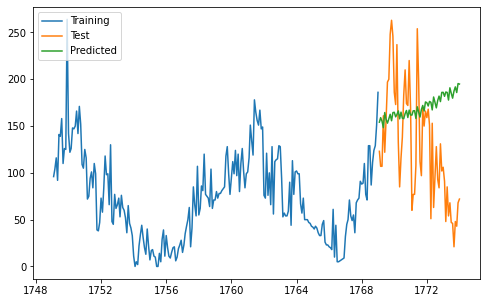

In [15]:
'''
결과 시각화
'''
plt.figure(figsize = (8, 5))
plt.plot(train_data_df, label = "Training")
plt.plot(test_data_df, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [16]:
'''
오차 및 정확도
'''
rmse = sqrt(mean_squared_error(test_data_df, prediction))
print('RMSE: %.3f' % rmse)

r2_score_ret = r2_score(test_data_df, prediction)
print('R2 Score: %.5f' % r2_score_ret)

RMSE: 79.474
R2 Score: -0.70943
